# ChessVision Performance Report

This notebook generates a full performance report of the ChessVision system.

### Imports

In [1]:
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import chessvision as cv
from test import run_tests, get_test_generator, plot_confusion_mtx, labels
import cv_globals
import cv2
import numpy as np
from model.u_net import load_extractor
from model.square_classifier import load_classifier

Using TensorFlow backend.


### Parameters

These variables will be filled in by papermill. 
(Default to using current best models)

In [2]:
classifier_weights = cv_globals.square_weights
extractor_weights  = cv_globals.board_weights
threshold          = 80

### Load models and test data generator

In [3]:
data_generator = get_test_generator()
extractor      = load_extractor(weights=extractor_weights)
classifier     = load_classifier(weights=classifier_weights)

Loading board extraction model..
Loading board extraction model.. DONE
Loading square model..
Loading square model.. DONE


In [4]:
results = run_tests(data_generator, extractor, classifier, threshold)

Processing image 5460c35b-55c8-46d0-8132-06eb542a09d8.JPG
Processing image f29c1937-8279-45a5-a74a-0c6b1aa3ffbe.JPG
Processing image 8991e2f3-56cc-4ae3-a57d-69f8c9586efe.JPG
Processing image 3bf5c478-d745-4276-8f1a-d106328cbea5.JPG
Pawn (P) on first or last rank. Changing to B.
Processing image 325732c8-7fb2-47a3-a579-e335c304d0af.JPG
Processing image 6404e621-cc56-4db2-8970-76ea123e8a71.JPG
More than one white dark-squared bishop
At g7 with prob 1.0000000000
At c1 with prob 1.0000000000
Processing image f41748b5-9f3b-42d3-a820-406359bde123.JPG
Processing image 15eeff0a-a72a-42c6-b7da-fea889968554.JPG
Processing image 6de4021f-9f09-4013-96d2-79144147b4a4.JPG
Processing image 372f133c-e438-4dc6-bc2b-2dfe2073570d.JPG
More than one white light-squared bishop
At c8 with prob 1.0000000000
At h1 with prob 1.0000000000
Processing image 20c6dc38-a3d2-4916-865d-9ea852f73249.JPG
Processing image 76be4f7f-c712-47da-adb5-ec65d002b162.JPG
Pawn (P) on first or last rank. Changing to f.
Pawn (P) on f

### Get results

In [5]:
board_imgs = results["board_imgs"]
imgs = results["raw_imgs"]
predictions = results["predictions"]
boards = results["chessboards"]
squares = results["squares"]
acc = results["acc"]
board_accs = results["board_accs"]
avg_time = results["avg_time"]
avg_entropy = results["avg_entropy"]
squares = results["squares"]
masks = results["masks"]
errors = results["errors"]
top_2 = results["top_2_accuracy"]
top_3 = results["top_3_accuracy"]
ondiag, offdiag = results["hits"]
N = len(results["raw_imgs"])

In [6]:
print("Test suite accuracy: {:.1f}%".format(acc*100))
print("Top-2 accuracy: {:.1f}%".format(top_2*100))
print("Top-3 accuracy: {:.1f}%".format(top_3*100))
print("Average time per raw classification: {:.1f}s".format(avg_time))
print("Average entropy of classifier predictions: {:.2g}".format(avg_entropy))
print("Number of board extraction errors: {}".format(errors))
print("Overall correct piece classifications: {}/{} ({} incorrect)".format(ondiag, ondiag + offdiag, offdiag))

Test suite accuracy: 97.5%
Top-2 accuracy: 98.4%
Top-3 accuracy: 98.6%
Average time per raw classification: 0.9s
Average entropy of classifier predictions: 0.00033
Number of board extraction errors: 0
Overall correct piece classifications: 1248/1280 (32 incorrect)


### Confusion Matrix

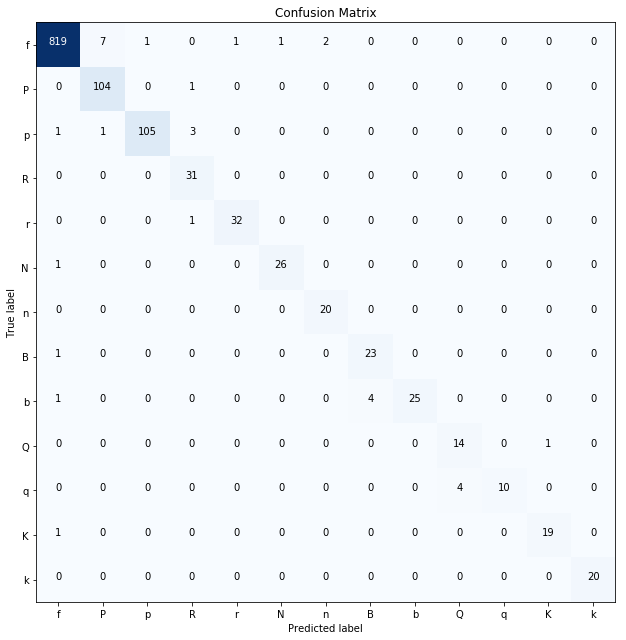

In [7]:
mtx = results["confusion_matrix"]
plt.figure(figsize=(9, 9))
plot_confusion_mtx(mtx, labels)
plt.show()

### Plot results

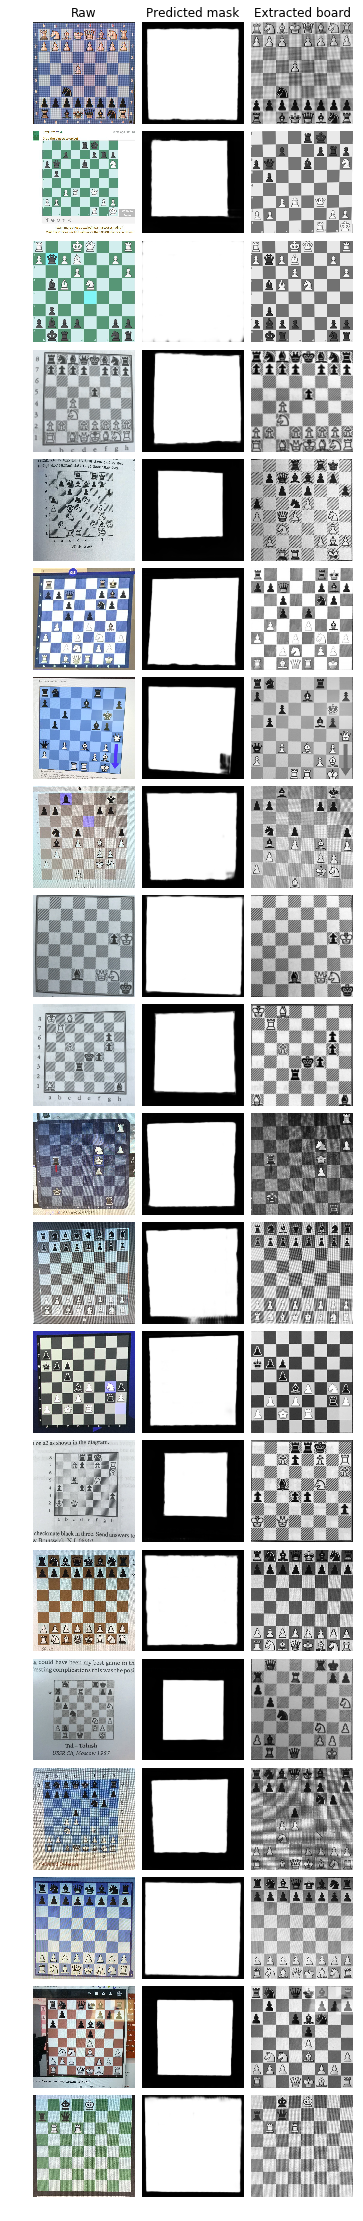

In [8]:
rows = N
cols = 3

fig = plt.figure(1, figsize=(12, 40)) #width, height in inches.

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 label_mode=None
                 )

for i in range(rows):
    raw = imgs[i]
    board = board_imgs[i]
    mask = cv2.resize(masks[i], (512, 512))
    
    ax1 = grid[cols*i]
    ax1.imshow(raw)
    ax1.axis("off")

    ax2 = grid[cols*i+1]
    ax2.imshow(mask.reshape((512, 512)), cmap="gray")
    ax2.axis("off")
    
    ax3 = grid[cols*i+2]
    ax3.imshow(board, cmap="gray")
    ax3.axis("off")
    
    if i == 0:
        ax1.set_title("Raw")
        ax2.set_title("Predicted mask")
        ax3.set_title("Extracted board")

#plt.savefig("../../img/training_extraction.png", bbox_inches="tight")
plt.show()


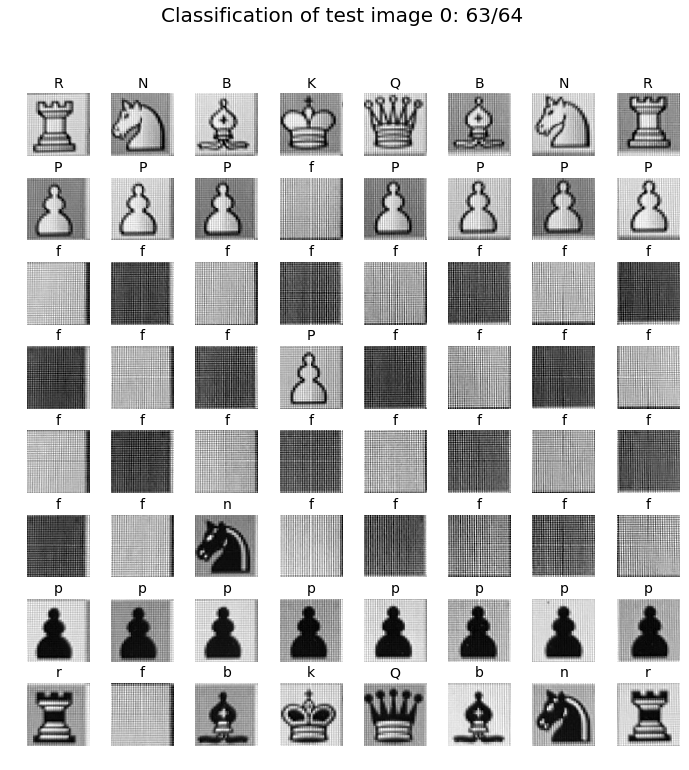

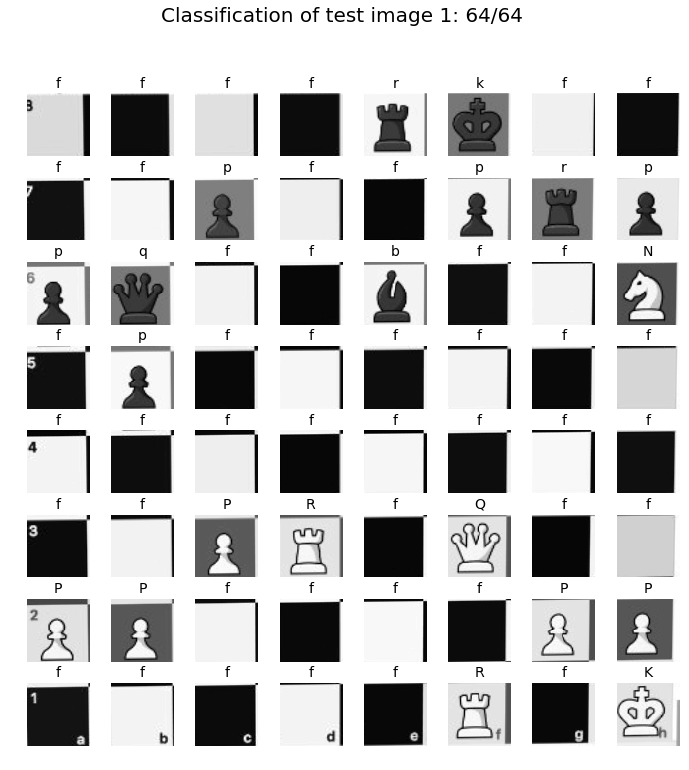

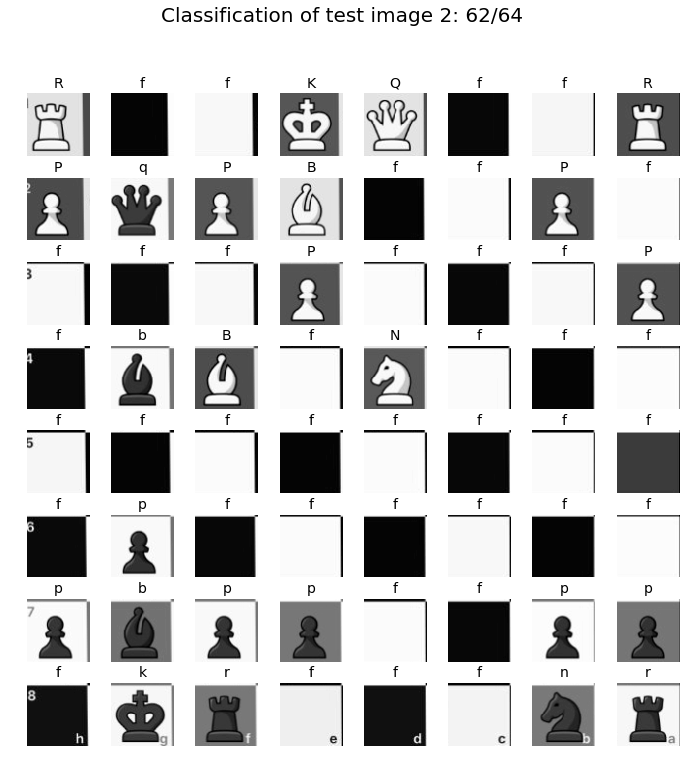

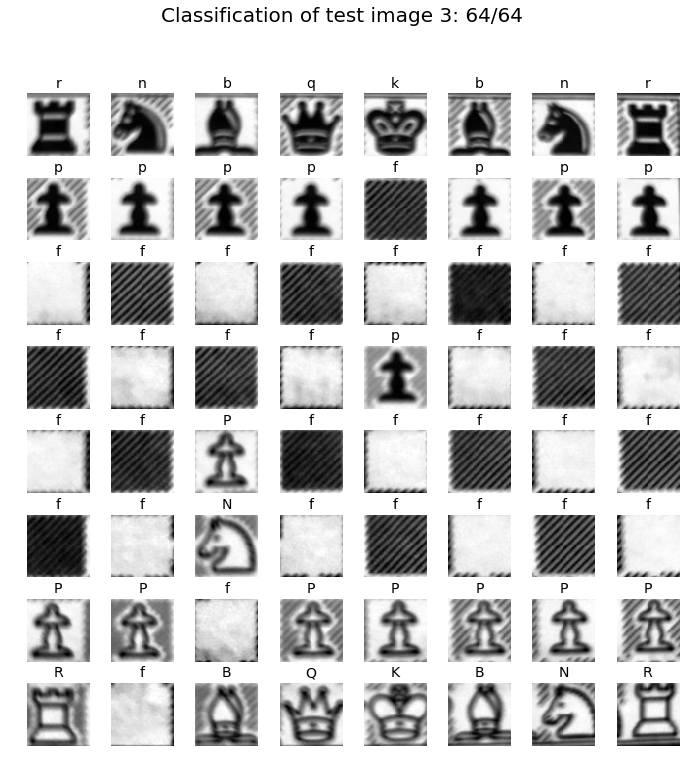

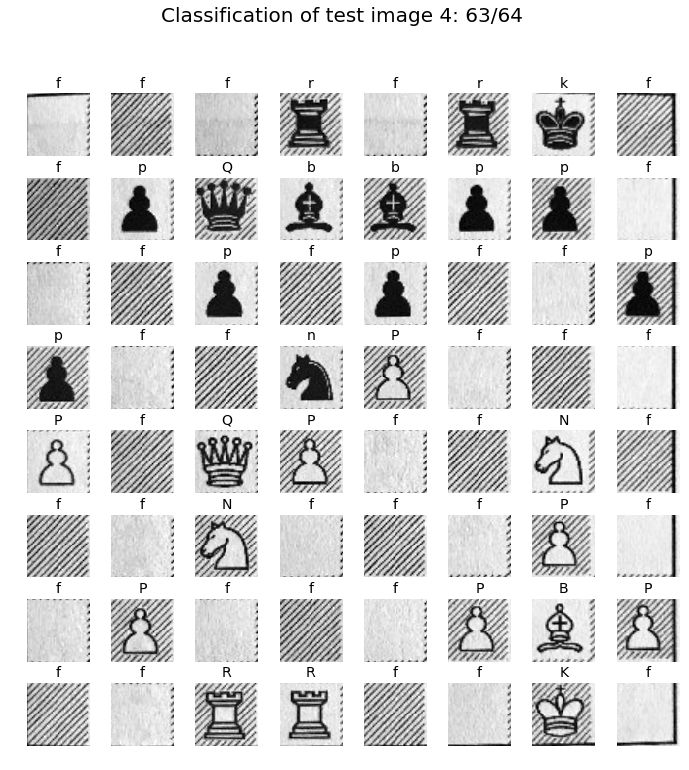

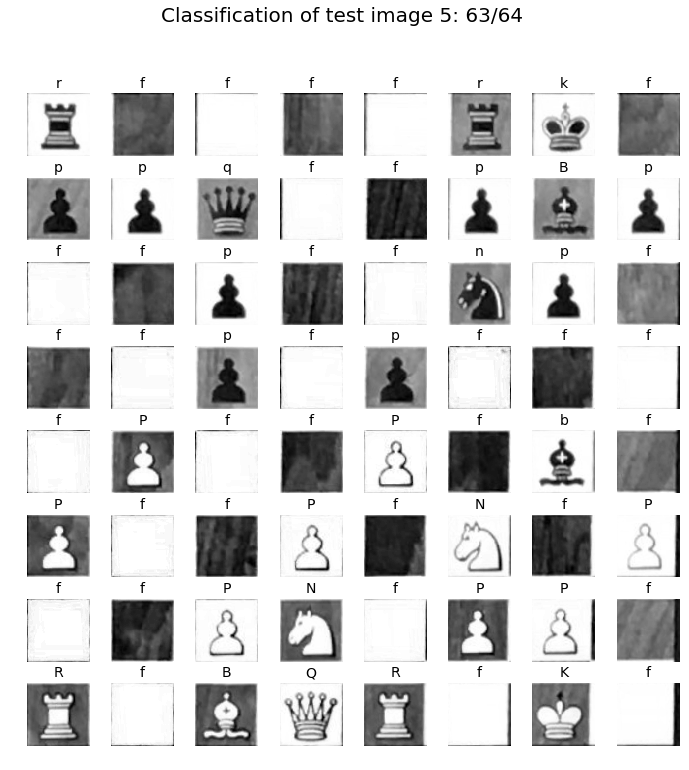

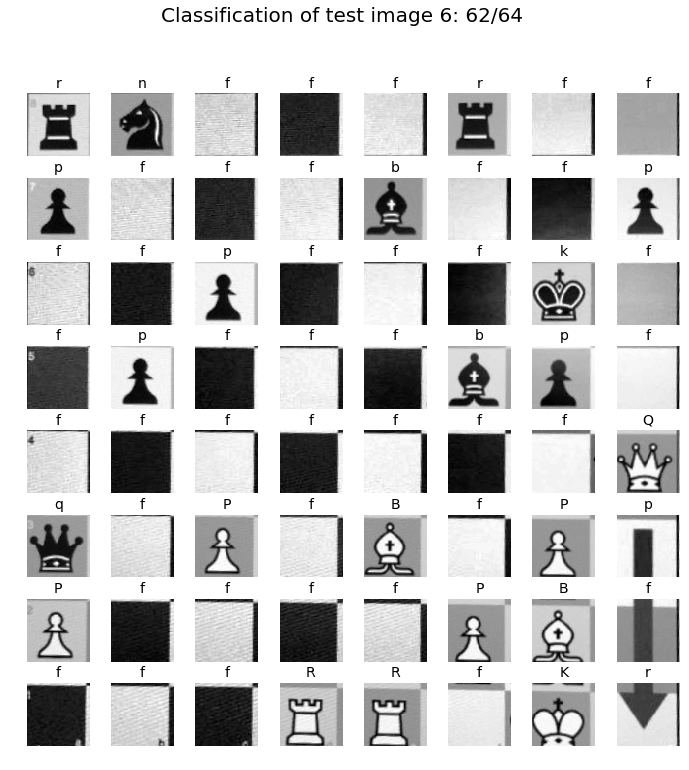

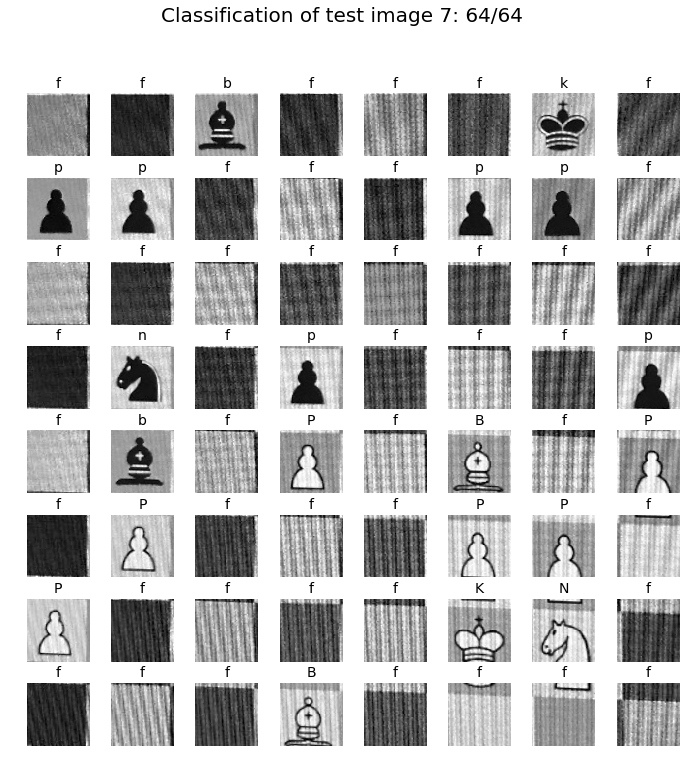

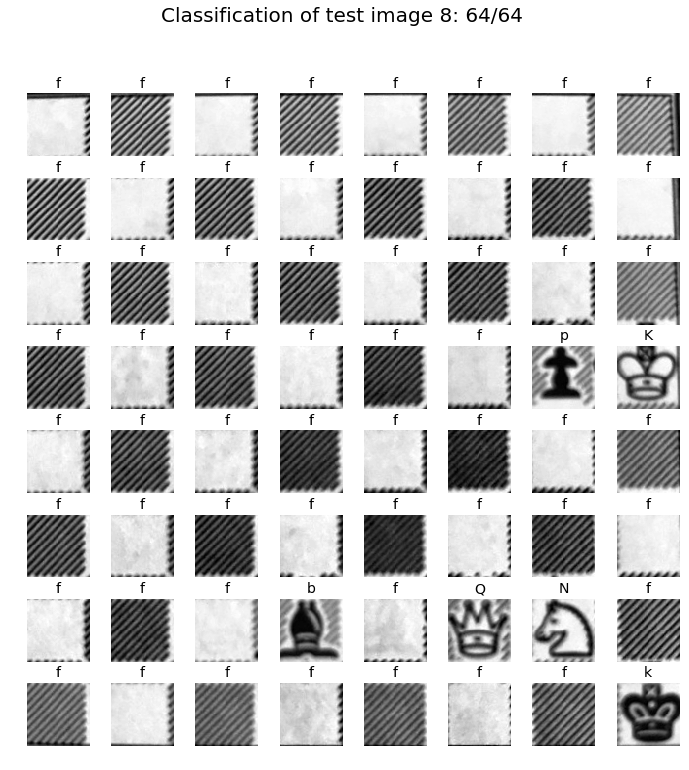

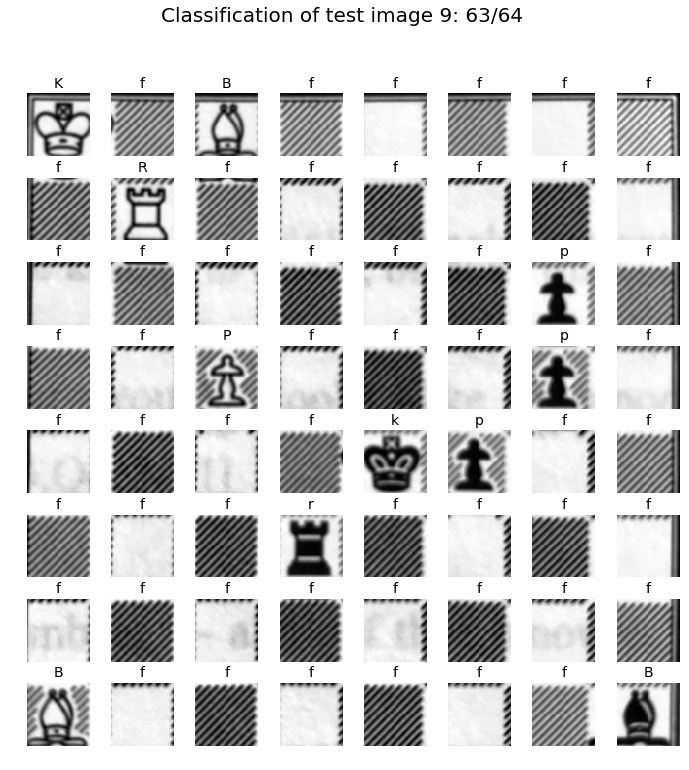

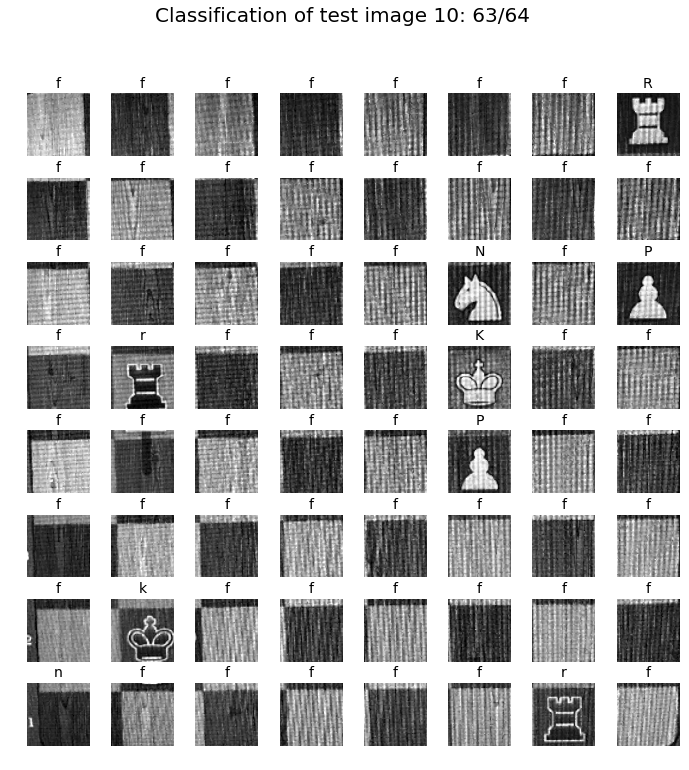

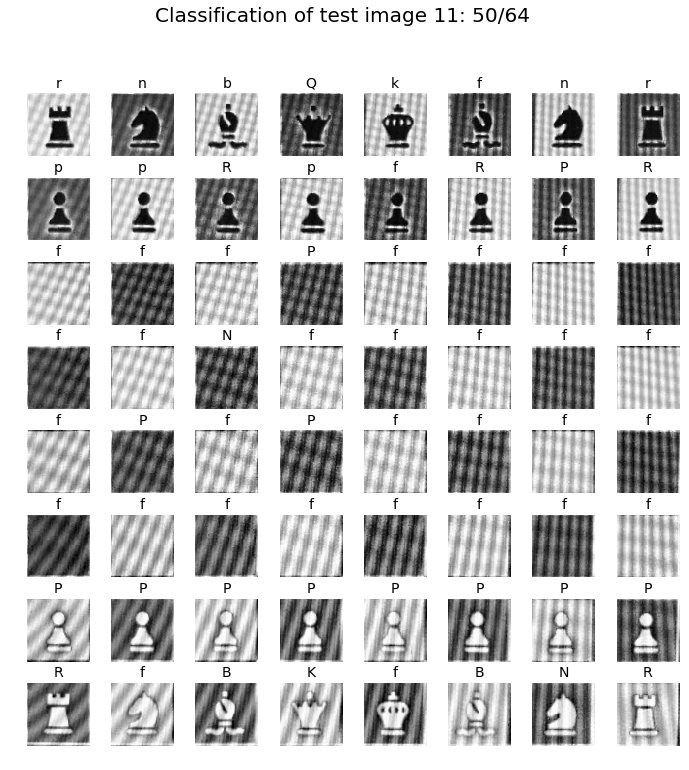

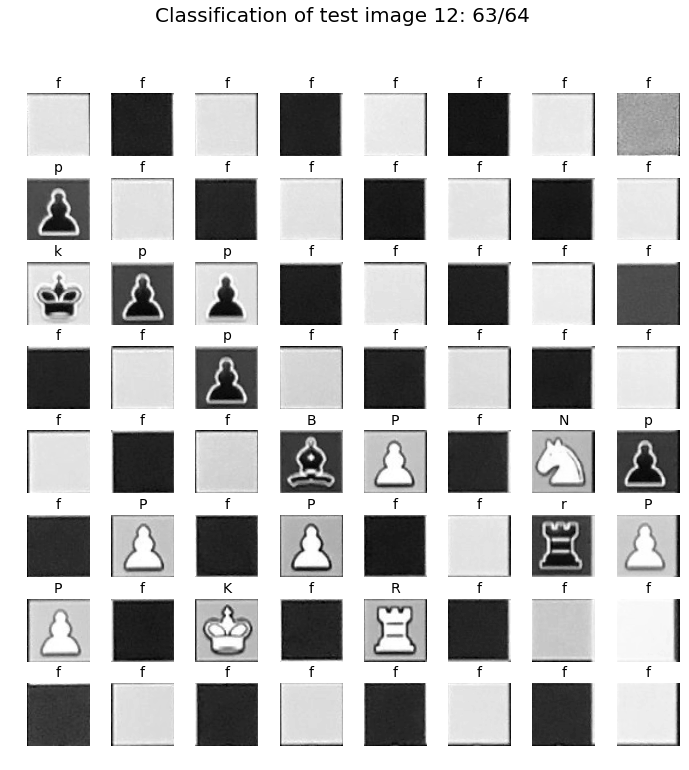

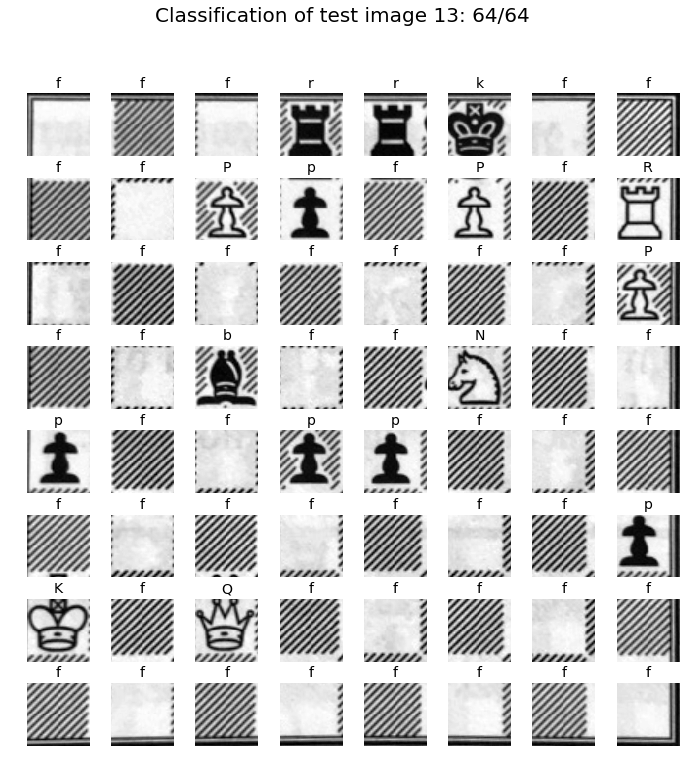

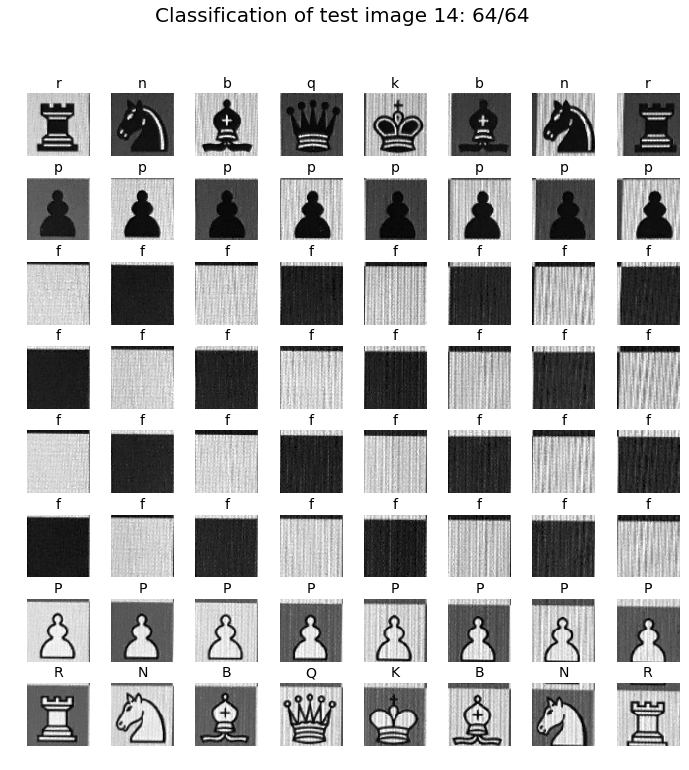

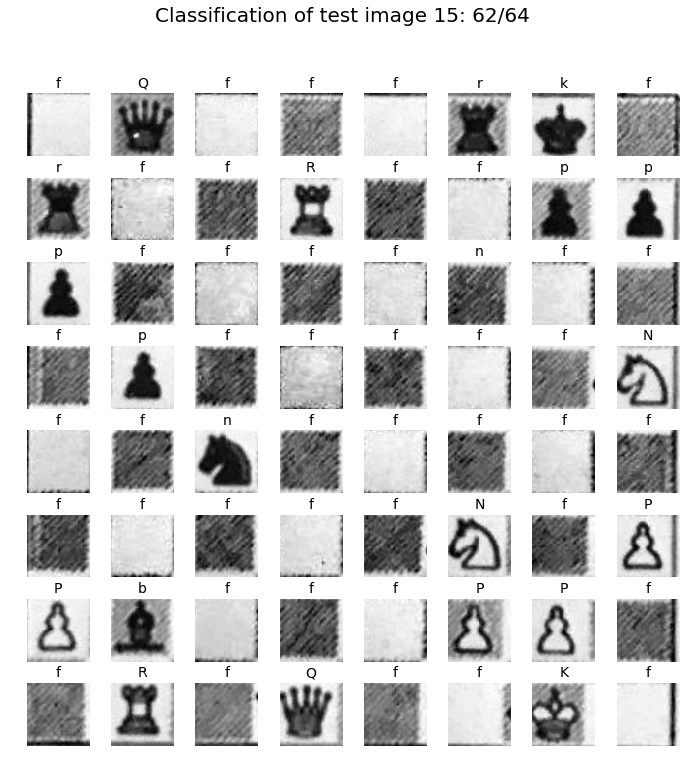

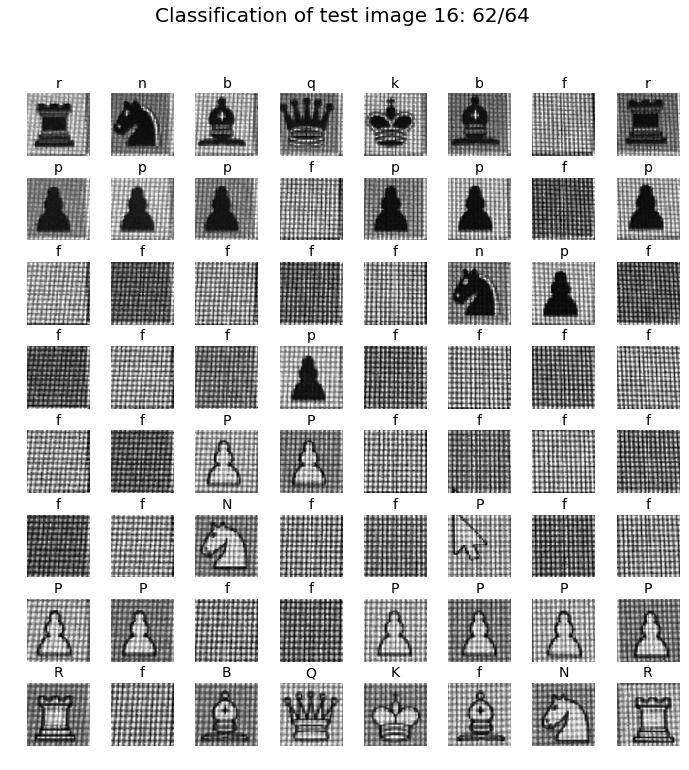

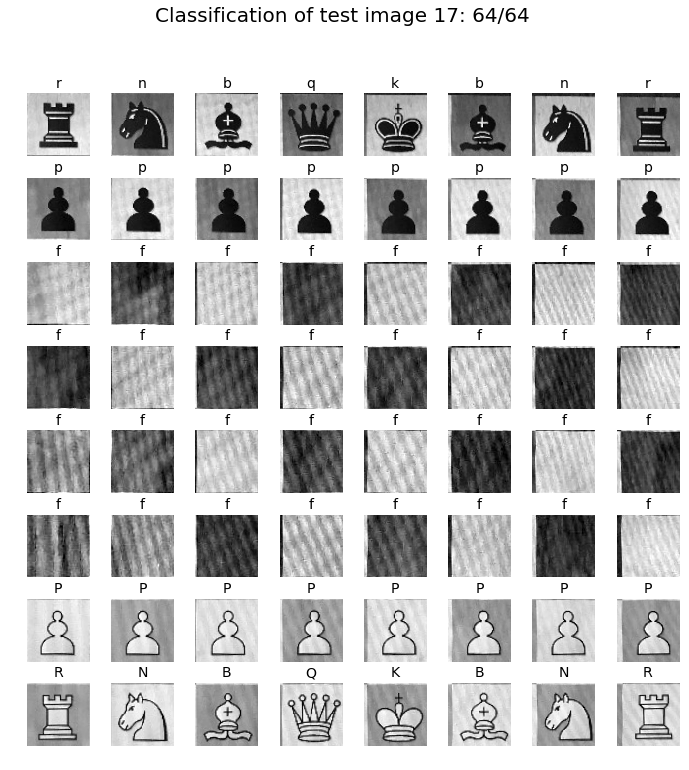

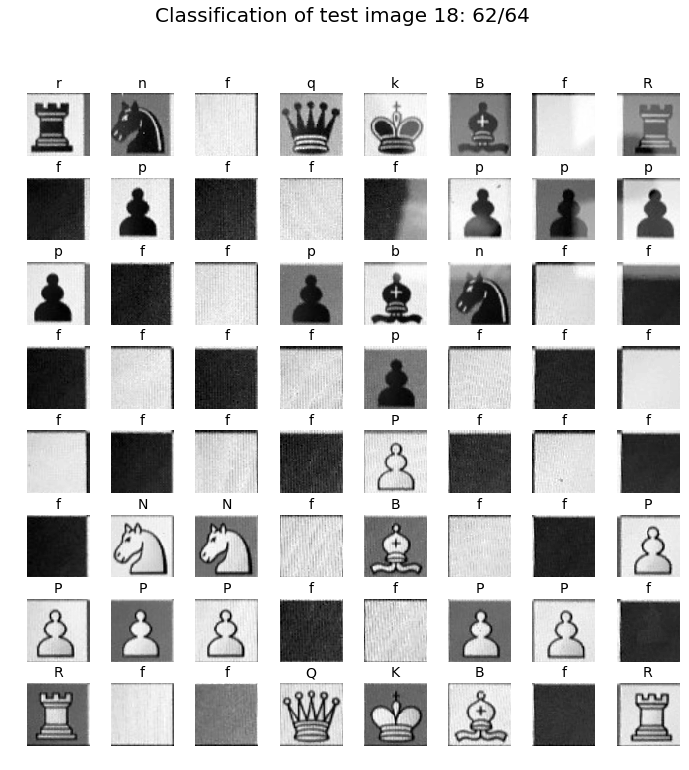

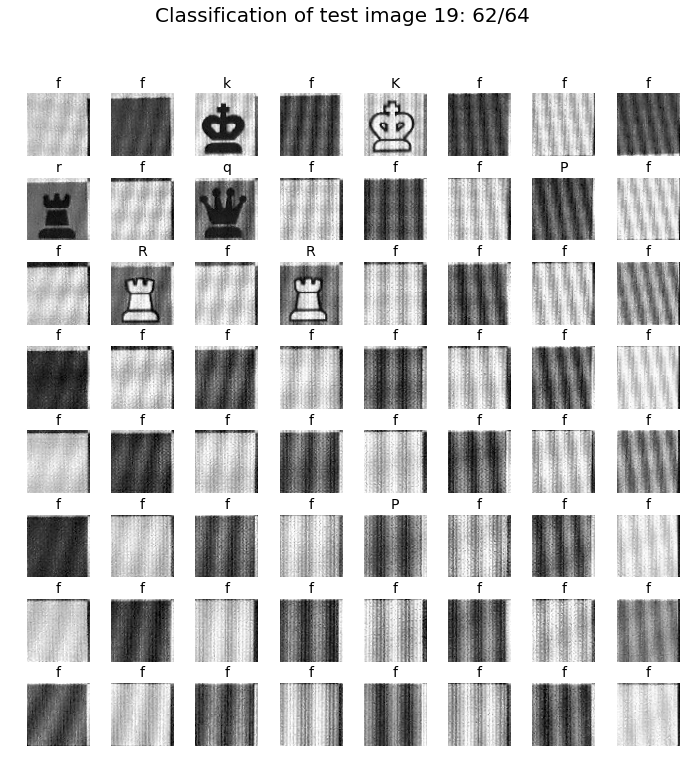

In [9]:
label_names  = ['B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r', 'f']

for k in range(N):

    piecemap = boards[k].piece_map()
    pred_labels = ["f"] * 64
    for piece in piecemap:
        pred_labels[piece] = piecemap[piece].symbol()
    pred_labels = list(reversed(pred_labels))
    for i in range(8):
        pred_labels[i*8:(i+1)*8] = list(reversed(pred_labels[i*8:(i+1)*8]))
    
    square_grid = squares[k]
    # Plot
    rows, cols = 8, 8
    fig = plt.figure(figsize=(12, 12))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     label_mode=None
                     )

    for i in range(cols):
        for j in range(rows):
            ind = cols*i+j
            im = square_grid[ind]
            label = pred_labels[ind]
            grid[ind].imshow(im.reshape(64, 64), cmap="gray")
            grid[ind].set_title(label, size=14, fontweight=3)
            grid[ind].axis("off")

    plt.suptitle("Classification of test image {}: {}/64".format(k, int(64*board_accs[k])), size=20, fontweight=5)